In [ ]:
import copy
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import json

path = F"/content/gdrive/My Drive/Model-wise Double Descent/log.json"

with open(path) as f:
  log = json.load(f)

In [ ]:
log

[{'nparameters': '', 'training_loss': '', 'test_loss': ''},
 {'nparameters': 805,
  'training_loss': 0.07738388329744339,
  'test_loss': 0.07929391413927078},
 {'nparameters': 3985,
  'training_loss': 0.06789878755807877,
  'test_loss': 0.07063966989517212},
 {'nparameters': 7960,
  'training_loss': 0.00783693790435791,
  'test_loss': 0.054386429488658905},
 {'nparameters': 19885,
  'training_loss': 0.0008756144670769572,
  'test_loss': 0.040153998881578445},
 {'nparameters': 35785,
  'training_loss': 0.000497737608384341,
  'test_loss': 0.029486054554581642},
 {'nparameters': 36580,
  'training_loss': 0.0009558104793541133,
  'test_loss': 0.02733639068901539},
 {'nparameters': 37375,
  'training_loss': 0.0005806735134683549,
  'test_loss': 0.029139293357729912},
 {'nparameters': 38170,
  'training_loss': 0.001027540653012693,
  'test_loss': 0.02899189107120037},
 {'nparameters': 38965,
  'training_loss': 0.00023213606618810445,
  'test_loss': 0.02686425857245922},
 {'nparameters': 397

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

train_dataset = torchvision.datasets.MNIST(root='/data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='/data', 
                                          train=False, 
                                          transform=transforms.ToTensor())


In [ ]:
train_4000 = torch.utils.data.Subset(train_dataset, range(0, 4000))

In [ ]:
# Data loader
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_4000, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


In [ ]:
class FCNN(nn.Module):

  def __init__(self, input_size, num_hidden, num_classes):
    super(FCNN, self).__init__()
    self.fc1 = nn.Linear(input_size, num_hidden)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(num_hidden, num_classes)

  def forward(self, x):

    y = self.fc1(x)
    y = self.relu(y)
    y = self.fc2(y)

    return y

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 784
num_classes = 10
num_hidden = 54

model = FCNN(input_size, num_hidden, num_classes)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

42940

In [ ]:
num_epochs = 6000
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.95)
total_step = len(train_loader)

training_losses = []
test_losses = []
interpolation = 0

for epoch in range(num_epochs):

  for i, (images, labels) in enumerate(train_loader):

          images = images.reshape(-1, 28*28).to(device)
          labels = labels.to(device)
          labels = torch.nn.functional.one_hot(labels, 10).float()
          # Forward pass
          outputs = model(images)
          train_loss = criterion(outputs, labels)
          
          # Backpropagation and optimization
          optimizer.zero_grad()
          train_loss.backward()
          optimizer.step()

          if interpolation == 0:
            if train_loss == 0:
              interpolation = 1
              training_losses.append(train_loss.item())
              
              with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in test_loader:
                    images = images.reshape(-1, 28*28).to(device)
                    labels = labels.to(device)
                    labels = torch.nn.functional.one_hot(labels, 10).float()
                    outputs = model(images)
                    test_loss = criterion(outputs, labels)
                
              test_losses.append(test_loss.item())

              print ('Model: FCNN-{} Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f}, Test Loss: {:.4f}' 
                  .format(count_parameters(model), epoch+1, num_epochs, i+1, total_step, train_loss.item(), test_loss.item()))
              break

          if epoch % 100 == 0 and i + 1 == len(train_loader):

            training_losses.append(train_loss.item())
            
            with torch.no_grad():
              correct = 0
              total = 0
              for images, labels in test_loader:
                  images = images.reshape(-1, 28*28).to(device)
                  labels = labels.to(device)
                  labels = torch.nn.functional.one_hot(labels, 10).float()
                  outputs = model(images)
                  test_loss = criterion(outputs, labels)
              
            test_losses.append(test_loss.item())

            print ('Model: FCNN-{} Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f}, Test Loss: {:.4f}' 
                .format(count_parameters(model), epoch+1, num_epochs, i+1, total_step, train_loss.item(), test_loss.item()))

Model: FCNN-42940 Epoch [1/6000], Step [40/40], Training Loss: 0.0751, Test Loss: 0.0761
Model: FCNN-42940 Epoch [101/6000], Step [40/40], Training Loss: 0.0119, Test Loss: 0.0236
Model: FCNN-42940 Epoch [201/6000], Step [40/40], Training Loss: 0.0102, Test Loss: 0.0223
Model: FCNN-42940 Epoch [301/6000], Step [40/40], Training Loss: 0.0070, Test Loss: 0.0225
Model: FCNN-42940 Epoch [401/6000], Step [40/40], Training Loss: 0.0067, Test Loss: 0.0222
Model: FCNN-42940 Epoch [501/6000], Step [40/40], Training Loss: 0.0050, Test Loss: 0.0221
Model: FCNN-42940 Epoch [601/6000], Step [40/40], Training Loss: 0.0036, Test Loss: 0.0223
Model: FCNN-42940 Epoch [701/6000], Step [40/40], Training Loss: 0.0039, Test Loss: 0.0225
Model: FCNN-42940 Epoch [801/6000], Step [40/40], Training Loss: 0.0038, Test Loss: 0.0224
Model: FCNN-42940 Epoch [901/6000], Step [40/40], Training Loss: 0.0035, Test Loss: 0.0226
Model: FCNN-42940 Epoch [1001/6000], Step [40/40], Training Loss: 0.0026, Test Loss: 0.0230


In [ ]:
log.append({"nparameters": count_parameters(model), "training_loss": train_loss.item(), "test_loss": test_loss.item()})

with open(path, 'w') as f:
  json.dump(log, f, indent = 4, separators = (',',': '))

In [ ]:
log

[{'nparameters': '', 'training_loss': '', 'test_loss': ''},
 {'nparameters': 805,
  'training_loss': 0.07738388329744339,
  'test_loss': 0.07929391413927078},
 {'nparameters': 3985,
  'training_loss': 0.06789878755807877,
  'test_loss': 0.07063966989517212},
 {'nparameters': 7960,
  'training_loss': 0.00783693790435791,
  'test_loss': 0.054386429488658905},
 {'nparameters': 19885,
  'training_loss': 0.0008756144670769572,
  'test_loss': 0.040153998881578445},
 {'nparameters': 35785,
  'training_loss': 0.000497737608384341,
  'test_loss': 0.029486054554581642},
 {'nparameters': 36580,
  'training_loss': 0.0009558104793541133,
  'test_loss': 0.02733639068901539},
 {'nparameters': 37375,
  'training_loss': 0.0005806735134683549,
  'test_loss': 0.029139293357729912},
 {'nparameters': 38170,
  'training_loss': 0.001027540653012693,
  'test_loss': 0.02899189107120037},
 {'nparameters': 38965,
  'training_loss': 0.00023213606618810445,
  'test_loss': 0.02686425857245922},
 {'nparameters': 397

In [ ]:
nparameters = []
training_loss = []
test_loss = []

for i, entry in enumerate(log):
  if i == 0:
    continue
  nparameters.append(log[i]['nparameters'])
  training_loss.append(log[i]['training_loss'])
  test_loss.append(log[i]['test_loss'])


In [ ]:
training_loss

[0.07738388329744339,
 0.06789878755807877,
 0.00783693790435791,
 0.0008756144670769572,
 0.000497737608384341,
 0.0009558104793541133,
 0.0005806735134683549,
 0.001027540653012693,
 0.00023213606618810445,
 0.0007313163368962705,
 0.0005330168642103672,
 0.0005897636874578893,
 0.0003463141620159149,
 0.0005422817775979638,
 0.0004336029523983598,
 0.00033640244510024786,
 0.000566061120480299,
 0.0002864047419279814,
 2.3129292458179407e-05,
 3.726444447238464e-06,
 3.726444447238464e-06,
 4.442143506366847e-07]

In [ ]:
test_loss

[0.07929391413927078,
 0.07063966989517212,
 0.054386429488658905,
 0.040153998881578445,
 0.029486054554581642,
 0.02733639068901539,
 0.029139293357729912,
 0.02899189107120037,
 0.02686425857245922,
 0.027198979631066322,
 0.027672480791807175,
 0.029876239597797394,
 0.027158593758940697,
 0.025609349831938744,
 0.024948149919509888,
 0.02254289574921131,
 0.024594534188508987,
 0.021885158494114876,
 0.01868629641830921,
 0.01663803681731224,
 0.01663803681731224,
 0.016701089218258858]

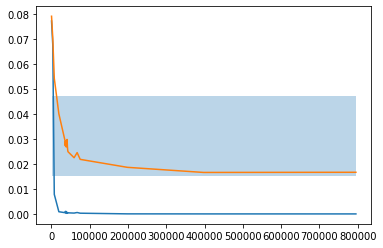

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(nparameters, training_loss)
plt.plot(nparameters, test_loss)

plt.show()